__“DRY” (Do Not Repeat Yourself) - semantic search using with Pinecone & OpenAI Embeddings__
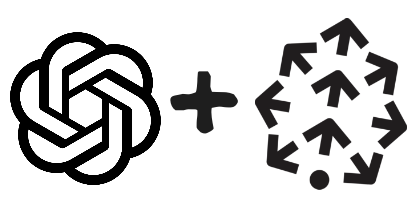

In [ ]:
# Set the needed environment variables
# "env" file example:
'''
OPENAI_API_KEY="<get at openai.com, e.g. sk-UuesomethingSomethingTICeE>""
OPENAI_ORG=<get at openai.com, e.g. org-hdBsOmEtHiNg4ws>
PINECONE_ENVIRONMENT=<get at pinecone.io, e.g. us-west1-gcp-free
PINECONE_API_KEY=<get at pinecone.io, some uuid-format string>
PINECONE_INDEX_NAME=<pinecone index name, e.g. dry>
SIMILARITY_SEARCH_LIMIT=0.9
TOP_K=5
'''

import os
env_vars = !cat env
for var in env_vars:
  key, value = var.split('=')
  os.environ[key] = value

print(os.getenv('PINECONE_INDEX_NAME', 'pinecone index name not found - check if the env variables are set correctly'))

In [ ]:
# API integrations initialisation (shared code)
%pip install tiktoken
%pip install openai
%pip install pinecone-client

import os
import tiktoken
import openai
import pinecone

tokenizer = tiktoken.get_encoding('gpt2')

openai.api_key = os.getenv('OPENAI_API_KEY')
openai.organization = os.getenv('OPENAI_ORG')

PINECONE_INDEX_NAME = os.getenv('PINECONE_INDEX_NAME', 'dry')
EMBEDDINGS_MODEL = "text-embedding-ada-002"
INDEX_DIMENSIONS = 1536 # specific for "text-embedding-ada-002" model

pinecone.init(
    api_key = os.getenv('PINECONE_API_KEY'),
    environment = os.getenv('PINECONE_ENVIRONMENT', 'us-west1-gcp-free')
)

# check requests to OpenAI
print('OpenAI Engines: ', openai.Engine.list())

# check requests to Pinecone by listing the indexes
print('Pinecone Indexes: ', pinecone.list_indexes())

# check if PINECONE_INDEX_NAME index already exists (only create index if not)
if PINECONE_INDEX_NAME not in pinecone.list_indexes():
    pinecone.create_index(PINECONE_INDEX_NAME, dimension=INDEX_DIMENSIONS)

# connect to the Pinecone index
index = pinecone.Index(PINECONE_INDEX_NAME)

In [ ]:
# Test messages to check saving vectors and metadata to the database
test_messages = [
    {
      'text': 'Доброго вечора, де можна в Любляні чи Ново место поміняти різну валюту на евро ? (Не долари) підскажіть, будь ласка',
      'author': 'author-1',
      'date': '2023-06-04T10:45:52Z',
      'url': 'https://t.me/somechat/1/79738'
    },
    {
      'text': 'Наразі обмін валюти тільки в банках. Пошта раніше міняла, зараз - ні.',
      'author': 'author-2',
      'date': '2023-06-04T10:50:52Z',
      'url': 'https://t.me/somechat/1/79744'
    },
    {
      'text': 'Доброго дня, підскажіть будь ласка перевізників які беруть посилки з України в Марібор, дякую.',
      'author': 'author-3',
      'date': '2023-06-03T10:45:52Z',
      'url': 'https://t.me/somechat/1/79675'
    }
]

In [ ]:
# create an embeddings vector
def get_embeddings_vector(string):
  res = openai.Embedding.create(input=[string], engine=EMBEDDINGS_MODEL)
  embeds = [record['embedding'] for record in res['data']]
  print(f'Generated embeddings for the string "{string[0:100]}", dimensions: {len(embeds[0])}')
  return embeds

In [ ]:
# save the vector and the original message + metadata (chat_id, timestamp, author) to Pinecone
def get_vector_id(meta):
  vector_id_part1 = meta['date']
  vector_id_part2 = meta['url'].split('/')[-1]
  vector_id = f'{vector_id_part1}-{vector_id_part2}'
  print(f'vector_id = {vector_id}')
  return vector_id

In [ ]:
def save_vector_plus_meta(embeds, meta):
  vector_id = get_vector_id(meta)
  to_upsert = (
      vector_id,
      embeds,
      meta) # meta (source text and other fields)
  index.upsert(vectors=[to_upsert])
  print(f'Vector #{vector_id} was upserted OK')

In [ ]:
for message in test_messages:
  embeds = get_embeddings_vector(message["text"])
  save_vector_plus_meta(embeds, message)

In [ ]:
# Search for top relevant messages (generate a vector for a message, search for messages using similarity search)
def get_top_relevant_messages(text):
  embeds = get_embeddings_vector(text)

  res = index.query(
      embeds,
      top_k=int(os.getenv('TOP_K')),
      include_metadata=True
      )

  relevance_limit = float(os.getenv("SIMILARITY_SEARCH_LIMIT"))
  relevant_matches = []

  print("All matches:")
  for match in res["matches"]:
    print(f'-- {round(match["score"], 2)}: {match["metadata"]["text"]}')
    if match["score"] >= relevance_limit: # 0.9
      print(">>>>> IT'S A MATCH!!! <<<<")
      match["metadata"]["score"] = match["score"]
      relevant_matches.append(match["metadata"])

  if len(relevant_matches) == 0:
    print("No relevant matches found")
  else:
    print("Relevant matches:")
    [print(f'-- {round(relevant_match["score"], 2)}: {relevant_match["text"]}: {relevant_match["url"]}') for relevant_match in relevant_matches]
  return relevant_matches, embeds

In [ ]:
print("TOP_K=", int(os.getenv('TOP_K')))
print("SIMILARITY_SEARCH_LIMIT=", float(os.getenv("SIMILARITY_SEARCH_LIMIT")))

In [ ]:
# Test messages to check the similarity search
test_message_1 = "Де в Любляні поміняти валюту?"
test_message_2 = "Шукаю перевізника з України"
test_message_3 = "Хто отримав одлочбу цього місяця?"


In [ ]:
get_top_relevant_messages(test_message_1)

In [ ]:
get_top_relevant_messages(test_message_2)

In [ ]:
get_top_relevant_messages(test_message_3)

In [ ]:
# Example of message processing (search for similar messages, save the message into the vector DB)
def get_similar_and_store(meta):
  relevant_messages, embeds = get_top_relevant_messages(meta["text"])
  save_vector_plus_meta(embeds, meta)

In [ ]:
# Test messages to check the whole setup (similarity search + saving each new message to the DB)
msg= [
"Добрий вечір! Підкажіть будь ласка, хто отримав підтвердження на фінансову допомогу і компенсацію за житло чи доплатили вам за ті місяці де була вже підвищена допомога !?🙏",
"да, кожного разу перераховують, в +, чи -",
"Яка мінімальна виплата за житло",
"трошки послухайте, якщо вас це дійсно цікавить",
"Якщо одна особа виплачуе",
"Якщо Людина працює і положила допомога на житло якщо вона живе в приватному будинку",
"І оплачує сама",
"Дуже вибачаюсь, але читайте те, що пишите, ставте розділові знаки, бо неможливо зрозуміти, що ви питаєте. Люди б раді допомогти інформацією, але просто не розуміють.",
"Чи положена допомога на житло якщо  людина працює",
"І живе приватному будинку",
"ні",
"ви працюєте і отримуєте допомогу?",
"ви забули додати що маєте 3 дитини. Коли людина сама, то зп більша ніж допомога і людина не отримує допомогу.",
"Якщо немає дітей то не положила допомога на житло",
"А людина працює",
"якщо  зп більша ні сума допомоги, то допомогу не платять",
"Хтось трохи раніше писав: що, наприклад, якщо отримуєш зарплату 500 євро офіційно, то 500 вираховують з допомоги і також 500 вираховують з компенсації за житло",
"Так, вони це можуть(.  Мої батьки не подавали на матеріальну допомогу,  бо отримують пенсію. Але подавали на допомогу на житло, бо пенсія зовсім невелика. В результаті допомогу на житло не отримали, тому що є пенсія.",
"Доброго дня.  Хто робив паспорт через консула, підкажіть, будь ласка,  чи залишається старий паспорт на руках на період виготовлення нового? І чи потрібно приводити дітей на фото, або можна принести фото? Дякую",
"Доброго дня, старий залишається на руках. Можно без дитини, само принести фото",
"Дякую вам.  А ви не пам'ятаєте, який саме розмір фото?",
"Паспорт віддавала коли отримувала новий і дитину не возила. Фото 10*15 на білому фоні робила. Паспорт робили тим літом.",
"Тільки обовʼязково на білому фоні. Мені так консул казав. Я переробляла фото",
"Не зовсім вірно. Залежить від віку дитини. Для маленьких, консул робить вийняток і приймає готове фото. Для старших дітей присутність обовʼязкова",
"Доброго вечора,а якось візи переносяться? Наприклад щоб не було зайвих питань,яким чином і через який пункт перетинали кордон ЄС ?",
"Нічого з цього не знаю, бо їхала по укр паспорту",
"Я знаю,  що в Україні в чоловіка залишався старий паспорт разом з новим у випадку діючих віз. Мабуть, що тут така ж історія",
"Буду питати у Консула,дякую за відповідь!",
"Доброго вечора всім. Є питання по грошовій допомозі, може хтось мав подібну ситуацію. Я тут живу сама з 2 дітьми. Якщо я влаштуюсь на роботу і ЗП буде такою ж або вищою за мої виплати на себе і дітей, то виплати всі заберу, чи заберу тільки мої 421, а на дітей залишать?",
"Якщо буде більшою за нараховані виплати, то всю.",
"Я так розумію, зарплата вираховується з загальної допомоги на всю сім'ю, а не на кожного окремо",
"Ви подаєтесь всі разом, вам нарахована загальна сума. З неї і буде враховуватися усі доходи. І з фінансової допомоги, і з компенсації житла",
"Дякую всім. Так і думала, але надія на краще залишалась 😀",
"Otroški dodatek будуть платити. Але його розмір залежить від зарплати.",
"Всім привіт! Підскажіть будь ласка, чи можна з Грошової допомоги (з Революта), переводити гроші на укр рахунок?",
"Ні якого моніторингу немає, куди ідуть кошти з грошової допомоги?",
"Я переводила на приват. Це було видно в виписці. Але допомогу нараховували",
"я б так не сказала..не держить словенців за дурнів.. соціальну допомогу платять для цілей проживання та харчування біженців (осіб зі статусом тимчасового захисту).. просто тут все повільно роблять, у тому числі і фінманіторинг. Якщо ви регулярно переказуєте гроші на інші рахунки, рано чи пізно вами зацікавляться.  Мабуть вам гроші тут й непотрібні..Знаю випадки коли довелося писати пояснювальні записки з приводу того, чому гроші знімаються регулярно  готівкою в банкоматі, і з іншого боку - чому якусь суму було зараховано або покладено через банкомат на рахунок (наприклад, потрібно було зробити платіж, а коштів на банківському рахунку  було недостатньо).",
"Доброго ранку! Скажіть будь ласка, чи вказано у ваших договорах оренди суму податку? Подала документи на компенсацію оренди житла, а у мене госпа з Ураду питає чому у договорі немає суми податку...",
"дуже  дивне питання від уряду. Ні, сумми податку в договорі нема.",
"В договорі повинна бути вказана сума як ви платите за аренду. Принаймі в менє так",
"Так, сума вказана. І всі умови також прописані. Піду допитуватися чому питають.",
"Сума податку залежить від умов словенської сторони. Наприклад, пенсіонери не платять податки від доходів з оренди (тому часто оформлюють на пенсіонерів). То ж цій інформації не місце в договорі, бо ви не знаєте їх особистих умов. Повинна бути тільки та сума, що ви платите.",
"Підскажіть будь ласка скільки приблизно чекали загран паспорт від моменту паспорт виготовлен до моменту коли він приїхав и вже можна його отримати? Чекаю вже 3 місяця",
"Консул сказав що чекати ще від 1-3 місяців, а як із Вашого досвіду було? Поділиться будь ласка",
"Теж 3 місяці чекаємо. Неділю назад оновився статус на «виготовлено». Тож залишилось дочекатися поки він приїде в Словенію",
"Добрий день. Скажіть будь ласка, якщо хтось з таким вже стикався. Повернулися в Україну та повідомили уряд. Тільки отримали рішення, що потрібно повернути зайве нараховану фінансову допомогу за один місяць. В рішенні вказані реквізити для повернення: st. SI56 01100-6300109972, na sklic SI18-15423-4119991-22120022. Хтось розуміє що таке sklic та де його вносити. Дякую",
"У Словаччині(Братислава)відкрили сервісний центр, паспорти роблять за місяць",
"Sklic - це призначення платежу. В платіжних системах словенських банків це окремий рядок, який так і є Sklic. Але якщо ви робите оплату з іншого банку, то обовʼязково вкажіть його у рядку призначення платежу. Sklic іншими словами Referenca",
"Так, бачу 🤔 Я працюю з револютом як юр.особа, то там є призначення при формуванні платежу. Може ще хтось підкаже.",
"Є, Reference, просто автоматично пише Sent from Revolut, вручну можна поміняти",
"Хто до консула брал талон,всім приходило підтвердження?",
"Вам приходило підтвердження на пошту відразу?",
"Чекали з 20 березня і тільки написано що виготовлений сплатили і чекаємо доставку.",
"Наші приїхали приблизно через 1,5 місяці після виготовлення. За доставку не платили, дипломатичною поштою",
"Ви коли записувалися на дату до консула,вам приходило на е пошту підтвердити? Бо мені ні,может я зря чекаю?",
"Розібралися: вони хочуть щоб у договорі було вказано податковий номер орендодавця",
"Колись не так давно було повідомлення на сайті Посольства здається і писалося про технічний збій,що не генеруються автоматично листи з підтвердженням бронювання. Писали,що після того як в e- черзі проходило бронювання,потрібно було написати консулу на його мейл і якось вже він підтверджував бронювання ( вже не пам'ятаю як). Тобто умова прийому- це лист на ваш мейл з підтвердженням. Це гарантує прийом. Якщо лист не прийшов через технічний збій- напишіть чи зателефонуйте консулу ( вся інформація на сайті посольства)",
"Добрий вечір! Підкажіть, будь ласка, скільки максимальна сумма виплат за житло?",
"Доброго дня я якщо я працюю а брат мій ні і живемо приватному будинку чи положена допомога",
"Привіт усім!!! Я студент і  шукаю підробіток.  Я не володію словенською мовою, англійська слаба. Дякую усім хто допоможе🙏",
"Це ваші фантазії. Я регулярно з Револют платив на рахунків інших людей, ніяких питань при продовженні не виникало. Є закон, по ньому нараховується, а куди витрачаєте - то ваше особисте.",
"421€ (може трохи більше) + 30% на кожного члена сім'ї",
"Ваша зп буде відніматися від компенсації. Якщо вона більше, то немає сенсу на неї подаватися",
"Я коли питала, то сказали що максимум десь 520-550€. На дорослу людину + дитину до 18 років",
"Доброго дня! підкажіть, будь ласка, якщо олдочба закінчується 31.07, треба подаватись на подовження рівно за місяць? 30.06?",
"Підскажить будь ласка телефон на дунайській про фін.помічь?",
"1.07 відправляйте, щоб була виписка з банку за повний попередній місяць",
"Доброго дня. Будь-ласка, підкажіть адресу електронної пошти, на яку можна писати в Любляну щодо деталей по фінансовій допомозі. Щоб дослати документи, тощо..?",
"Я робила довіреність в банк на свого чоловіка, все ок, отримав і картку, і гроші. Але цю довіреність ще в Україні треба вносити в реєстр у нотаріуса, це коштувало ще стільки ж, як і сама довіреність. Срок дії довіреності 1 рік"
"На початку липня, коли буде виписка з банку за червень",
"Доброго дня якщо мій брат не працює нігде чи має право на допомогу",
"А скільки на одну особу допомога",
"Які потрібно документи щоб подати",
"При відкритті рахунку револют не можу пройти верифікацію, бо підтримка просить підтвердження адреси проживання: лист від комунальників, від державного закладу або іншої офіційної кореспонденції. Нажаль в Словенії недавно, тому нічого подібного в нас немає. Адреса на картці ТЗ (ісказніца) їх не влаштовує. Хто знає що робити, або чи є якісь аналоги револют де можна рахунок відкрити для отримання допомоги?",
"Вам давали декілька разів посилання, де шукати відповіді на ваші запитання. У кожного своя низка документів. Читайте, дивіться канал на ютубі і робіть висновки і збирайте документи",
"Доброго вечора! Може є серед нас українці, які офіційно працюють в Словенії, та вже змінили статус ТЗ на ВНЖ? Можете підказати яка там процедура? Та що треба зробити роботодавцю (якісь документи подати кудись)?",
"Процедура така: Ваш працедавець повинен дати влогу на робочий дозвіл для іноземця в завод за запослованье. На підставі робочего дозвола Управна Енота видає посвідку на тимчасове проживання. Але всі українці з тимчасовим захистом мають право працювати без робочого дозволу. Тому я дуже здивуюсь, якщо хтось проходив цю процедуру.",
"Податковий номер вам на пошту приходив? Можете, в такому разі, сфотографувати його",
"Ні, ми його вчора оформили і сьогодні особисто забрали аби вже завтра на допомогу податися.",
"Ізказніци теж не через пошту отримували?",
"Подзвонили, сказали прийти забрати ((",
"Прийде лист про нарахування допомоги. Але! Він прийде через пару тижнів, а треба зараз. А без верифікації навіть iban не дає.",
"Доброго дня, підкажіть будь-ласка, дізнатись статус рішення по фін допомозі можна тільки по телефону? Чи може через електронну пошту?",
"Ще не робили, бо не знайшли постійне житло і бронюємо по букінгу кожні 4-10 днів 😵‍💫",
"Добрий день. Підкажіть, будь ласка, якщо припиняється достроково контракт оренди житла, треба йти в єноту з орендодавцем повідомити про це, щоб зняли реєстрації(прописка). Чи треба власниці житла повідомити кудись про розірвання договору аренди?",
"Точно не пригадую, але Ви прописуєте свою українську адресу, бо Ви резидент України",
"Якщо отримуєте компенсацію за оренду, тоді необхідно протягом восьми днів подати прілогу 2 до ураду.",
"Якщо ви в мене питали, то вам необхідно подати прілогу 2 та повний новий пакет документів на компенсацію оренди за новою адресою.",
"Підкажіть, будь-ласка, скільки зараз приблизно люди чекають на видачу тимчасового захисту у Словенії?",
"Все залежить від міста, в якому будете робити. Орієнтовно 10 днів, в великих містах довше.",
"Доброго дня! Підкажіть, хто знає, після отримання захисту та  прописки автівку в єдності ставити на адресний облік?"
]

In [ ]:
res = []
for idx, message in enumerate(msg):
  if len(message) > 20:
    res.append({
      'text': message,
      'author': 'author-1',
      'date': '2023-06-04T10:45:52Z',
      'url': f'https://t.me/somechat/1/12456{idx}'
    })
print(res)
print(len(res))

In [ ]:
for doc in res:
  get_similar_and_store(doc)